# Model 4b Final Training & Kaggle Submission

## Why Model 4b?

From hyperparameter tuning experiments (notebook 12):
- **Model 1 (Optuna best)**: R² = +0.2686 after 2 epochs, 5 trials
- **Model 4a (Distillation)**: R² = +0.1449 after 2 epochs, 2 trials  
- **Model 4b (Auxiliary)**: R² = +0.5043 after 6 epochs (3+3) ✅ **WINNER!**

Model 4b is **88% better** than Optuna-tuned baseline with just 6 epochs!

## The Approach

**Phase 1: Auxiliary Pretraining (15 epochs)**
- Train CNN to predict NDVI, height, weather, state, species from images
- Forces model to learn visual patterns that correlate with tabular features
- Debug run achieved 82% state accuracy - model learned to "see" location!

**Phase 2: Biomass Fine-tuning (30 epochs)**
- Fine-tune pretrained CNN for biomass prediction
- Leverages implicit tabular understanding from Phase 1
- At inference: Only needs images!

## Training Plan

We'll train **3 variations** with different hyperparameters:
- **Variation A**: Baseline (3e-4 LR, 256 hidden, 0.2 dropout)
- **Variation B**: Higher LR (5e-4 LR, 256 hidden, 0.3 dropout)  
- **Variation C**: Larger head (3e-4 LR, 512 hidden, 0.25 dropout)

**Time estimate**: ~60 min per variation = **3 hours total**

**Expected final R²**: +0.65 to +0.70 (vs +0.7537 for multimodal reference)

---

## Part 1: Setup & Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm.auto import tqdm
import copy
from datetime import datetime

sns.set_style('whitegrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✓ Imports complete")

Using device: cpu
✓ Imports complete


In [2]:
# ========================
# CONFIGURATION
# ========================

# Training epochs
PHASE1_EPOCHS = 15  # Image → tabular pretraining
PHASE2_EPOCHS = 30  # Biomass fine-tuning

# Shared config
BATCH_SIZE = 16
TARGET_COLS = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']
COMPETITION_WEIGHTS = torch.tensor([0.1, 0.1, 0.1, 0.2, 0.5])

# 3 Hyperparameter variations to try
VARIATIONS = {
    'A_Baseline': {
        'phase1_lr': 3e-4,
        'phase2_lr': 3e-4,
        'phase2_backbone_lr': 1e-5,
        'hidden_dim': 256,
        'dropout': 0.2,
        'description': 'Baseline from debug run'
    },
    'B_HigherLR': {
        'phase1_lr': 5e-4,
        'phase2_lr': 5e-4,
        'phase2_backbone_lr': 5e-5,
        'hidden_dim': 256,
        'dropout': 0.3,
        'description': 'Higher learning rate, more dropout'
    },
    'C_LargerHead': {
        'phase1_lr': 3e-4,
        'phase2_lr': 3e-4,
        'phase2_backbone_lr': 1e-5,
        'hidden_dim': 512,
        'dropout': 0.25,
        'description': 'Larger hidden dimension'
    }
}

print(f"Configuration:")
print(f"  Phase 1 (Auxiliary): {PHASE1_EPOCHS} epochs")
print(f"  Phase 2 (Biomass): {PHASE2_EPOCHS} epochs")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Variations to train: {len(VARIATIONS)}")
print(f"\nVariations:")
for name, config in VARIATIONS.items():
    print(f"  {name}: {config['description']}")

Configuration:
  Phase 1 (Auxiliary): 15 epochs
  Phase 2 (Biomass): 30 epochs
  Batch size: 16
  Variations to train: 3

Variations:
  A_Baseline: Baseline from debug run
  B_HigherLR: Higher learning rate, more dropout
  C_LargerHead: Larger hidden dimension


In [3]:
# Load data
train_enriched = pd.read_csv('competition/train_enriched.csv')
train_enriched['Sampling_Date'] = pd.to_datetime(train_enriched['Sampling_Date'])
train_enriched['full_image_path'] = train_enriched['image_path'].apply(lambda x: f'competition/{x}')

# Train/val split
train_data, val_data = train_test_split(train_enriched, test_size=0.2, random_state=42)

print(f"Data loaded: {len(train_data)} train, {len(val_data)} val")
print(f"Targets: {TARGET_COLS}")

Data loaded: 285 train, 72 val
Targets: ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']


In [4]:
# Calculate target normalization stats (CRITICAL FIX!)
target_means = torch.tensor([train_data[col].mean() for col in TARGET_COLS], dtype=torch.float32)
target_stds = torch.tensor([train_data[col].std() for col in TARGET_COLS], dtype=torch.float32)

print("Target normalization statistics:")
for i, col in enumerate(TARGET_COLS):
    print(f"  {col:15s}: mean={target_means[i]:.2f}g, std={target_stds[i]:.2f}g")

print("\n✓ Will normalize all targets to mean=0, std=1 during training")

Target normalization statistics:
  Dry_Green_g    : mean=27.49g, std=26.19g
  Dry_Dead_g     : mean=12.01g, std=12.50g
  Dry_Clover_g   : mean=6.26g, std=11.75g
  GDM_g          : mean=33.74g, std=25.62g
  Dry_Total_g    : mean=45.75g, std=28.86g

✓ Will normalize all targets to mean=0, std=1 during training


In [5]:
# Prepare tabular features for auxiliary pretraining
weather_features = [
    'rainfall_7d', 'rainfall_30d',
    'temp_max_7d', 'temp_min_7d', 'temp_mean_7d', 'temp_mean_30d', 'temp_range_7d',
    'et0_7d', 'et0_30d',
    'water_balance_7d', 'water_balance_30d',
    'days_since_rain', 'daylength', 'season'
]

# Scale continuous features
continuous_features = weather_features + ['Pre_GSHH_NDVI', 'Height_Ave_cm']
scaler = StandardScaler()
train_data[continuous_features] = scaler.fit_transform(train_data[continuous_features])
val_data[continuous_features] = scaler.transform(val_data[continuous_features])

# Encode categorical
le_state = LabelEncoder()
le_species = LabelEncoder()
train_data['State_encoded'] = le_state.fit_transform(train_data['State'])
train_data['Species_encoded'] = le_species.fit_transform(train_data['Species'])
val_data['State_encoded'] = le_state.transform(val_data['State'])
val_data['Species_encoded'] = le_species.transform(val_data['Species'])

num_states = len(le_state.classes_)
num_species = len(le_species.classes_)

print("✓ Tabular features prepared")
print(f"  States: {num_states} ({list(le_state.classes_)})")
print(f"  Species: {num_species}")

✓ Tabular features prepared
  States: 4 (['NSW', 'Tas', 'Vic', 'WA'])
  Species: 15


### Dataset Classes

In [6]:
class NormalizedDataset(Dataset):
    """Image-only dataset with normalized targets."""
    def __init__(self, dataframe, target_means, target_stds, augment=False):
        self.df = dataframe.reset_index(drop=True)
        self.target_means = target_means
        self.target_stds = target_stds
        
        transform_list = [transforms.Resize((224, 224))]
        
        if augment:
            transform_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(10),
            ])
        
        transform_list.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        self.transform = transforms.Compose(transform_list)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['full_image_path']).convert('RGB')
        img = self.transform(img)
        
        targets = torch.tensor(row[TARGET_COLS].values.astype('float32'), dtype=torch.float32)
        targets_normalized = (targets - self.target_means) / self.target_stds
        
        return {
            'image': img,
            'targets': targets_normalized,
            'targets_original': targets
        }

class MultimodalDataset(Dataset):
    """Multimodal dataset for auxiliary pretraining."""
    def __init__(self, dataframe, target_means, target_stds, augment=False):
        self.df = dataframe.reset_index(drop=True)
        self.target_means = target_means
        self.target_stds = target_stds
        
        transform_list = [transforms.Resize((224, 224))]
        
        if augment:
            transform_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(10),
            ])
        
        transform_list.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        self.transform = transforms.Compose(transform_list)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Image
        img = Image.open(row['full_image_path']).convert('RGB')
        img = self.transform(img)
        
        # Tabular features
        weather = torch.tensor(row[weather_features].values.astype('float32'), dtype=torch.float32)
        ndvi = torch.tensor(row['Pre_GSHH_NDVI'], dtype=torch.float32)
        height = torch.tensor(row['Height_Ave_cm'], dtype=torch.float32)
        state = torch.tensor(row['State_encoded'], dtype=torch.long)
        species = torch.tensor(row['Species_encoded'], dtype=torch.long)
        
        # Targets
        targets = torch.tensor(row[TARGET_COLS].values.astype('float32'), dtype=torch.float32)
        targets_normalized = (targets - self.target_means) / self.target_stds
        
        return {
            'image': img,
            'weather': weather,
            'ndvi': ndvi,
            'height': height,
            'state': state,
            'species': species,
            'targets': targets_normalized,
            'targets_original': targets
        }

# Create datasets
train_dataset_simple = NormalizedDataset(train_data, target_means, target_stds, augment=True)
train_dataset_multi = MultimodalDataset(train_data, target_means, target_stds, augment=True)
val_dataset_simple = NormalizedDataset(val_data, target_means, target_stds, augment=False)
val_dataset_multi = MultimodalDataset(val_data, target_means, target_stds, augment=False)

print("✓ Dataset classes defined and instantiated")

✓ Dataset classes defined and instantiated


### Model Architecture

In [7]:
class AuxiliaryPretrainedModel(nn.Module):
    """Model 4b: Two-phase training with auxiliary tasks.
    
    Phase 1: Train to predict tabular features from images
    Phase 2: Fine-tune for biomass prediction
    
    At inference: Only needs image (learned implicit tabular patterns)
    """
    def __init__(self, num_outputs=5, hidden_dim=256, dropout=0.2, num_states=4, num_species=15):
        super().__init__()
        
        # Shared backbone: ResNet18
        self.backbone = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        
        # Phase 1: Auxiliary heads (predict tabular features from image)
        self.ndvi_head = nn.Linear(512, 1)           # Predict NDVI
        self.height_head = nn.Linear(512, 1)         # Predict height
        self.weather_head = nn.Linear(512, 14)       # Predict 14 weather features
        self.state_head = nn.Linear(512, num_states)     # Predict state (classification)
        self.species_head = nn.Linear(512, num_species)  # Predict species (classification)
        
        # Phase 2: Biomass prediction head (used after pretraining)
        self.biomass_head = nn.Sequential(
            nn.Linear(512, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_outputs)
        )
    
    def forward(self, x, mode='biomass'):
        features = self.backbone(x)
        features = features.flatten(1)
        
        if mode == 'auxiliary':
            # Phase 1: Predict tabular features
            return {
                'ndvi': self.ndvi_head(features),
                'height': self.height_head(features),
                'weather': self.weather_head(features),
                'state': self.state_head(features),
                'species': self.species_head(features)
            }
        else:  # mode == 'biomass'
            # Phase 2: Predict biomass
            return self.biomass_head(features)

print("✓ AuxiliaryPretrainedModel defined")

✓ AuxiliaryPretrainedModel defined


### Utility Functions

In [8]:
def calculate_competition_r2(predictions, targets):
    """Calculate competition R² (weighted)."""
    per_target_r2 = []
    competition_r2 = 0
    
    weights = COMPETITION_WEIGHTS.numpy()
    
    for i in range(5):
        r2 = r2_score(targets[:, i], predictions[:, i])
        per_target_r2.append(r2)
        competition_r2 += weights[i] * r2
    
    return competition_r2, per_target_r2

def auxiliary_loss(predictions, targets):
    """Multi-task loss for predicting tabular features."""
    loss_ndvi = F.mse_loss(predictions['ndvi'].squeeze(), targets['ndvi'])
    loss_height = F.mse_loss(predictions['height'].squeeze(), targets['height'])
    loss_weather = F.mse_loss(predictions['weather'], targets['weather'])
    loss_state = F.cross_entropy(predictions['state'], targets['state'])
    loss_species = F.cross_entropy(predictions['species'], targets['species'])
    
    # Weighted combination
    total_loss = (
        0.2 * loss_ndvi + 
        0.2 * loss_height + 
        0.3 * loss_weather + 
        0.15 * loss_state + 
        0.15 * loss_species
    )
    
    return total_loss, {
        'ndvi': loss_ndvi.item(),
        'height': loss_height.item(),
        'weather': loss_weather.item(),
        'state': loss_state.item(),
        'species': loss_species.item()
    }

print("✓ Utility functions defined")

✓ Utility functions defined


---
## Part 2: Training Functions

In [9]:
def train_phase1(model, train_loader, val_loader, num_epochs, lr, variation_name):
    """Phase 1: Train to predict tabular features from images."""
    print("\n" + "="*80)
    print(f"PHASE 1: AUXILIARY PRETRAINING - {variation_name}")
    print("="*80 + "\n")
    
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    history = {
        'train_loss': [], 
        'val_loss': [], 
        'val_ndvi_mae': [], 
        'val_state_acc': [],
        'val_species_acc': []
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images = batch['image'].to(device)
            targets = {
                'ndvi': batch['ndvi'].to(device),
                'height': batch['height'].to(device),
                'weather': batch['weather'].to(device),
                'state': batch['state'].to(device),
                'species': batch['species'].to(device)
            }
            
            optimizer.zero_grad()
            predictions = model(images, mode='auxiliary')
            loss, _ = auxiliary_loss(predictions, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        # Validate
        model.eval()
        val_loss = 0
        ndvi_errors = []
        state_correct = 0
        state_total = 0
        species_correct = 0
        species_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                targets = {
                    'ndvi': batch['ndvi'].to(device),
                    'height': batch['height'].to(device),
                    'weather': batch['weather'].to(device),
                    'state': batch['state'].to(device),
                    'species': batch['species'].to(device)
                }
                
                predictions = model(images, mode='auxiliary')
                loss, _ = auxiliary_loss(predictions, targets)
                val_loss += loss.item() * images.size(0)
                
                # NDVI MAE
                ndvi_errors.extend((predictions['ndvi'].squeeze().cpu() - targets['ndvi'].cpu()).abs().tolist())
                
                # State accuracy
                state_pred = predictions['state'].argmax(dim=1)
                state_correct += (state_pred == targets['state']).sum().item()
                state_total += targets['state'].size(0)
                
                # Species accuracy
                species_pred = predictions['species'].argmax(dim=1)
                species_correct += (species_pred == targets['species']).sum().item()
                species_total += targets['species'].size(0)
        
        val_loss /= len(val_loader.dataset)
        ndvi_mae = np.mean(ndvi_errors)
        state_acc = state_correct / state_total
        species_acc = species_correct / species_total
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_ndvi_mae'].append(ndvi_mae)
        history['val_state_acc'].append(state_acc)
        history['val_species_acc'].append(species_acc)
        
        # Print progress
        print(f"Epoch {epoch+1:2d}/{num_epochs}: "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"NDVI MAE={ndvi_mae:.4f}, State Acc={state_acc:.2%}, Species Acc={species_acc:.2%}")
        
        # Save best checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'model4b_{variation_name}_phase1_best.pth')
            print(f"  💾 Saved Phase 1 checkpoint (val_loss={val_loss:.4f})")
    
    print(f"\n✓ Phase 1 complete! Model learned to predict tabular features from images.")
    print(f"  Final State Accuracy: {state_acc:.2%} (model can 'see' location!)")
    print(f"  Final Species Accuracy: {species_acc:.2%}")
    print(f"  Final NDVI MAE: {ndvi_mae:.4f}\n")
    
    return history

print("✓ train_phase1() defined")

✓ train_phase1() defined


In [10]:
def train_phase2(model, train_loader, val_loader, num_epochs, lr_head, lr_backbone, variation_name):
    """Phase 2: Fine-tune for biomass prediction."""
    print("\n" + "="*80)
    print(f"PHASE 2: BIOMASS FINE-TUNING - {variation_name}")
    print("="*80 + "\n")
    
    model = model.to(device)
    
    # Two learning rates: low for pretrained backbone, higher for new head
    optimizer = torch.optim.AdamW([
        {'params': model.backbone.parameters(), 'lr': lr_backbone},
        {'params': model.biomass_head.parameters(), 'lr': lr_head}
    ], weight_decay=1e-4)
    
    criterion = nn.MSELoss()
    history = {'train_loss': [], 'val_loss': [], 'val_r2': [], 'per_target_r2': [], 'epoch': []}
    best_r2 = -float('inf')
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images = batch['image'].to(device)
            targets = batch['targets'].to(device)
            
            optimizer.zero_grad()
            outputs = model(images, mode='biomass')
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        # Validate
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                targets = batch['targets'].to(device)
                targets_original = batch['targets_original']
                
                outputs = model(images, mode='biomass')
                loss = criterion(outputs, targets)
                val_loss += loss.item() * images.size(0)
                
                # Denormalize for R² calculation
                outputs_denorm = outputs.cpu() * target_stds + target_means
                all_preds.append(outputs_denorm.numpy())
                all_targets.append(targets_original.numpy())
        
        val_loss /= len(val_loader.dataset)
        
        # Calculate R²
        all_preds = np.vstack(all_preds)
        all_targets = np.vstack(all_targets)
        val_r2, per_target_r2 = calculate_competition_r2(all_preds, all_targets)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_r2'].append(val_r2)
        history['per_target_r2'].append(per_target_r2)
        history['epoch'].append(epoch + 1)
        
        # Print progress
        print(f"Epoch {epoch+1:2d}/{num_epochs}: "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val R²={val_r2:+.4f}")
        
        # Save best checkpoint
        if val_r2 > best_r2:
            best_r2 = val_r2
            torch.save(model.state_dict(), f'model4b_{variation_name}_phase2_best.pth')
            print(f"  💾 New best R²={best_r2:+.4f} - checkpoint saved")
    
    print(f"\n✓ Phase 2 complete! Best R²={best_r2:+.4f}")
    print(f"\nPer-target R² scores (at best epoch):")
    best_epoch_idx = np.argmax(history['val_r2'])
    best_per_target = history['per_target_r2'][best_epoch_idx]
    for i, col in enumerate(TARGET_COLS):
        print(f"  {col:15s}: R²={best_per_target[i]:+.4f}")
    print()
    
    return history, best_r2

print("✓ train_phase2() defined")

✓ train_phase2() defined


---
## Part 3: Train All Variations

We'll train each variation sequentially and track results.

In [11]:
# Storage for all results
all_results = {}

print("="*80)
print("TRAINING ALL VARIATIONS")
print("="*80)
print(f"\nStarting at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nWill train {len(VARIATIONS)} variations:")
for name, config in VARIATIONS.items():
    print(f"  {name}: {config['description']}")
print("\nEstimated time: ~60 min per variation = 3 hours total\n")

TRAINING ALL VARIATIONS

Starting at: 2025-11-04 15:42:38

Will train 3 variations:
  A_Baseline: Baseline from debug run
  B_HigherLR: Higher learning rate, more dropout
  C_LargerHead: Larger hidden dimension

Estimated time: ~60 min per variation = 3 hours total



In [12]:
# Train each variation
for var_name, config in VARIATIONS.items():
    print("\n\n")
    print("#" * 80)
    print(f"# TRAINING VARIATION: {var_name}")
    print(f"# Description: {config['description']}")
    print("#" * 80)
    
    # Create model
    model = AuxiliaryPretrainedModel(
        num_outputs=5,
        hidden_dim=config['hidden_dim'],
        dropout=config['dropout'],
        num_states=num_states,
        num_species=num_species
    )
    
    # Create dataloaders
    train_loader_multi = DataLoader(train_dataset_multi, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader_multi = DataLoader(val_dataset_multi, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    train_loader_simple = DataLoader(train_dataset_simple, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader_simple = DataLoader(val_dataset_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    # Phase 1: Auxiliary pretraining
    history_p1 = train_phase1(
        model=model,
        train_loader=train_loader_multi,
        val_loader=val_loader_multi,
        num_epochs=PHASE1_EPOCHS,
        lr=config['phase1_lr'],
        variation_name=var_name
    )
    
    # Phase 2: Biomass fine-tuning
    history_p2, best_r2 = train_phase2(
        model=model,
        train_loader=train_loader_simple,
        val_loader=val_loader_simple,
        num_epochs=PHASE2_EPOCHS,
        lr_head=config['phase2_lr'],
        lr_backbone=config['phase2_backbone_lr'],
        variation_name=var_name
    )
    
    # Store results
    all_results[var_name] = {
        'config': config,
        'history_phase1': history_p1,
        'history_phase2': history_p2,
        'best_r2': best_r2,
        'model_checkpoint': f'model4b_{var_name}_phase2_best.pth'
    }
    
    print(f"\n✅ {var_name} complete! Best R²={best_r2:+.4f}")
    print(f"   Checkpoint: model4b_{var_name}_phase2_best.pth")




################################################################################
# TRAINING VARIATION: A_Baseline
# Description: Baseline from debug run
################################################################################

PHASE 1: AUXILIARY PRETRAINING - A_Baseline



Epoch 1/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/15: Train Loss=1.1110, Val Loss=1.1558, NDVI MAE=0.9212, State Acc=61.11%, Species Acc=37.50%
  💾 Saved Phase 1 checkpoint (val_loss=1.1558)


Epoch 2/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/15: Train Loss=0.6760, Val Loss=1.0156, NDVI MAE=0.4552, State Acc=62.50%, Species Acc=50.00%
  💾 Saved Phase 1 checkpoint (val_loss=1.0156)


Epoch 3/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/15: Train Loss=0.5492, Val Loss=0.6918, NDVI MAE=0.4352, State Acc=65.28%, Species Acc=55.56%
  💾 Saved Phase 1 checkpoint (val_loss=0.6918)


Epoch 4/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/15: Train Loss=0.4643, Val Loss=0.4770, NDVI MAE=0.4085, State Acc=83.33%, Species Acc=79.17%
  💾 Saved Phase 1 checkpoint (val_loss=0.4770)


Epoch 5/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/15: Train Loss=0.4264, Val Loss=0.6308, NDVI MAE=0.5762, State Acc=81.94%, Species Acc=70.83%


Epoch 6/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/15: Train Loss=0.3819, Val Loss=0.5637, NDVI MAE=0.4176, State Acc=83.33%, Species Acc=65.28%


Epoch 7/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/15: Train Loss=0.3320, Val Loss=0.5166, NDVI MAE=0.4847, State Acc=77.78%, Species Acc=77.78%


Epoch 8/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/15: Train Loss=0.3253, Val Loss=0.4712, NDVI MAE=0.4423, State Acc=81.94%, Species Acc=65.28%
  💾 Saved Phase 1 checkpoint (val_loss=0.4712)


Epoch 9/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/15: Train Loss=0.2942, Val Loss=0.5362, NDVI MAE=0.4255, State Acc=81.94%, Species Acc=69.44%


Epoch 10/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/15: Train Loss=0.2777, Val Loss=0.5136, NDVI MAE=0.3758, State Acc=75.00%, Species Acc=73.61%


Epoch 11/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/15: Train Loss=0.2377, Val Loss=0.3215, NDVI MAE=0.2579, State Acc=86.11%, Species Acc=70.83%
  💾 Saved Phase 1 checkpoint (val_loss=0.3215)


Epoch 12/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/15: Train Loss=0.2658, Val Loss=0.3737, NDVI MAE=0.2877, State Acc=86.11%, Species Acc=75.00%


Epoch 13/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/15: Train Loss=0.2101, Val Loss=0.3425, NDVI MAE=0.4034, State Acc=90.28%, Species Acc=76.39%


Epoch 14/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/15: Train Loss=0.1940, Val Loss=0.3254, NDVI MAE=0.2667, State Acc=88.89%, Species Acc=79.17%


Epoch 15/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/15: Train Loss=0.1852, Val Loss=0.3346, NDVI MAE=0.3508, State Acc=91.67%, Species Acc=75.00%

✓ Phase 1 complete! Model learned to predict tabular features from images.
  Final State Accuracy: 91.67% (model can 'see' location!)
  Final Species Accuracy: 75.00%
  Final NDVI MAE: 0.3508


PHASE 2: BIOMASS FINE-TUNING - A_Baseline



Epoch 1/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/30: Train Loss=0.7428, Val Loss=0.6026, Val R²=+0.2640
  💾 New best R²=+0.2640 - checkpoint saved


Epoch 2/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/30: Train Loss=0.5390, Val Loss=0.4628, Val R²=+0.5046
  💾 New best R²=+0.5046 - checkpoint saved


Epoch 3/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/30: Train Loss=0.4665, Val Loss=0.4226, Val R²=+0.5503
  💾 New best R²=+0.5503 - checkpoint saved


Epoch 4/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/30: Train Loss=0.3909, Val Loss=0.3999, Val R²=+0.5682
  💾 New best R²=+0.5682 - checkpoint saved


Epoch 5/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/30: Train Loss=0.3923, Val Loss=0.3643, Val R²=+0.6145
  💾 New best R²=+0.6145 - checkpoint saved


Epoch 6/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/30: Train Loss=0.3424, Val Loss=0.3529, Val R²=+0.6201
  💾 New best R²=+0.6201 - checkpoint saved


Epoch 7/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/30: Train Loss=0.3551, Val Loss=0.3509, Val R²=+0.6152


Epoch 8/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/30: Train Loss=0.3195, Val Loss=0.3639, Val R²=+0.6050


Epoch 9/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/30: Train Loss=0.3343, Val Loss=0.3561, Val R²=+0.6268
  💾 New best R²=+0.6268 - checkpoint saved


Epoch 10/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/30: Train Loss=0.3003, Val Loss=0.3462, Val R²=+0.6357
  💾 New best R²=+0.6357 - checkpoint saved


Epoch 11/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/30: Train Loss=0.3039, Val Loss=0.3468, Val R²=+0.6415
  💾 New best R²=+0.6415 - checkpoint saved


Epoch 12/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/30: Train Loss=0.2837, Val Loss=0.3542, Val R²=+0.6321


Epoch 13/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/30: Train Loss=0.2787, Val Loss=0.3376, Val R²=+0.6519
  💾 New best R²=+0.6519 - checkpoint saved


Epoch 14/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/30: Train Loss=0.2750, Val Loss=0.3414, Val R²=+0.6477


Epoch 15/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/30: Train Loss=0.2905, Val Loss=0.3667, Val R²=+0.6114


Epoch 16/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/30: Train Loss=0.2573, Val Loss=0.3270, Val R²=+0.6702
  💾 New best R²=+0.6702 - checkpoint saved


Epoch 17/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/30: Train Loss=0.2416, Val Loss=0.3510, Val R²=+0.6428


Epoch 18/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/30: Train Loss=0.2348, Val Loss=0.3348, Val R²=+0.6648


Epoch 19/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/30: Train Loss=0.2520, Val Loss=0.3595, Val R²=+0.6281


Epoch 20/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/30: Train Loss=0.2442, Val Loss=0.3315, Val R²=+0.6671


Epoch 21/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21/30: Train Loss=0.2166, Val Loss=0.3309, Val R²=+0.6744
  💾 New best R²=+0.6744 - checkpoint saved


Epoch 22/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22/30: Train Loss=0.2213, Val Loss=0.3366, Val R²=+0.6615


Epoch 23/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23/30: Train Loss=0.2273, Val Loss=0.3366, Val R²=+0.6638


Epoch 24/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24/30: Train Loss=0.2081, Val Loss=0.3342, Val R²=+0.6746
  💾 New best R²=+0.6746 - checkpoint saved


Epoch 25/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25/30: Train Loss=0.2103, Val Loss=0.3335, Val R²=+0.6744


Epoch 26/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26/30: Train Loss=0.2116, Val Loss=0.3329, Val R²=+0.6789
  💾 New best R²=+0.6789 - checkpoint saved


Epoch 27/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27/30: Train Loss=0.1953, Val Loss=0.3475, Val R²=+0.6582


Epoch 28/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28/30: Train Loss=0.2266, Val Loss=0.3200, Val R²=+0.6847
  💾 New best R²=+0.6847 - checkpoint saved


Epoch 29/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29/30: Train Loss=0.1765, Val Loss=0.3307, Val R²=+0.6852
  💾 New best R²=+0.6852 - checkpoint saved


Epoch 30/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30/30: Train Loss=0.1980, Val Loss=0.3367, Val R²=+0.6736

✓ Phase 2 complete! Best R²=+0.6852

Per-target R² scores (at best epoch):
  Dry_Green_g    : R²=+0.7241
  Dry_Dead_g     : R²=+0.4170
  Dry_Clover_g   : R²=+0.5548
  GDM_g          : R²=+0.7975
  Dry_Total_g    : R²=+0.7123


✅ A_Baseline complete! Best R²=+0.6852
   Checkpoint: model4b_A_Baseline_phase2_best.pth



################################################################################
# TRAINING VARIATION: B_HigherLR
# Description: Higher learning rate, more dropout
################################################################################

PHASE 1: AUXILIARY PRETRAINING - B_HigherLR



Epoch 1/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/15: Train Loss=1.1556, Val Loss=1.0970, NDVI MAE=0.7346, State Acc=66.67%, Species Acc=47.22%
  💾 Saved Phase 1 checkpoint (val_loss=1.0970)


Epoch 2/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/15: Train Loss=0.7340, Val Loss=1.0011, NDVI MAE=0.6980, State Acc=68.06%, Species Acc=54.17%
  💾 Saved Phase 1 checkpoint (val_loss=1.0011)


Epoch 3/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/15: Train Loss=0.6035, Val Loss=0.9409, NDVI MAE=0.4831, State Acc=72.22%, Species Acc=52.78%
  💾 Saved Phase 1 checkpoint (val_loss=0.9409)


Epoch 4/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/15: Train Loss=0.5005, Val Loss=0.6484, NDVI MAE=0.4615, State Acc=80.56%, Species Acc=62.50%
  💾 Saved Phase 1 checkpoint (val_loss=0.6484)


Epoch 5/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/15: Train Loss=0.5336, Val Loss=1.2302, NDVI MAE=0.4846, State Acc=61.11%, Species Acc=45.83%


Epoch 6/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/15: Train Loss=0.4781, Val Loss=0.8049, NDVI MAE=0.5078, State Acc=77.78%, Species Acc=66.67%


Epoch 7/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/15: Train Loss=0.4027, Val Loss=0.6227, NDVI MAE=0.5056, State Acc=79.17%, Species Acc=62.50%
  💾 Saved Phase 1 checkpoint (val_loss=0.6227)


Epoch 8/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/15: Train Loss=0.3945, Val Loss=0.6638, NDVI MAE=0.4552, State Acc=75.00%, Species Acc=51.39%


Epoch 9/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/15: Train Loss=0.3659, Val Loss=0.4799, NDVI MAE=0.4013, State Acc=76.39%, Species Acc=72.22%
  💾 Saved Phase 1 checkpoint (val_loss=0.4799)


Epoch 10/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/15: Train Loss=0.3613, Val Loss=0.4140, NDVI MAE=0.3926, State Acc=90.28%, Species Acc=73.61%
  💾 Saved Phase 1 checkpoint (val_loss=0.4140)


Epoch 11/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/15: Train Loss=0.2951, Val Loss=0.3782, NDVI MAE=0.3558, State Acc=81.94%, Species Acc=77.78%
  💾 Saved Phase 1 checkpoint (val_loss=0.3782)


Epoch 12/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/15: Train Loss=0.2895, Val Loss=0.5724, NDVI MAE=0.4255, State Acc=72.22%, Species Acc=66.67%


Epoch 13/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/15: Train Loss=0.2841, Val Loss=0.4808, NDVI MAE=0.3805, State Acc=86.11%, Species Acc=73.61%


Epoch 14/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/15: Train Loss=0.2363, Val Loss=0.3612, NDVI MAE=0.3480, State Acc=84.72%, Species Acc=77.78%
  💾 Saved Phase 1 checkpoint (val_loss=0.3612)


Epoch 15/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/15: Train Loss=0.2179, Val Loss=0.3699, NDVI MAE=0.3548, State Acc=80.56%, Species Acc=84.72%

✓ Phase 1 complete! Model learned to predict tabular features from images.
  Final State Accuracy: 80.56% (model can 'see' location!)
  Final Species Accuracy: 84.72%
  Final NDVI MAE: 0.3548


PHASE 2: BIOMASS FINE-TUNING - B_HigherLR



Epoch 1/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/30: Train Loss=0.8226, Val Loss=0.5438, Val R²=+0.3954
  💾 New best R²=+0.3954 - checkpoint saved


Epoch 2/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/30: Train Loss=0.5160, Val Loss=0.4327, Val R²=+0.5328
  💾 New best R²=+0.5328 - checkpoint saved


Epoch 3/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/30: Train Loss=0.4225, Val Loss=0.3881, Val R²=+0.5869
  💾 New best R²=+0.5869 - checkpoint saved


Epoch 4/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/30: Train Loss=0.3562, Val Loss=0.3716, Val R²=+0.6087
  💾 New best R²=+0.6087 - checkpoint saved


Epoch 5/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/30: Train Loss=0.3385, Val Loss=0.3532, Val R²=+0.6517
  💾 New best R²=+0.6517 - checkpoint saved


Epoch 6/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/30: Train Loss=0.3314, Val Loss=0.3920, Val R²=+0.6060


Epoch 7/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/30: Train Loss=0.3099, Val Loss=0.3691, Val R²=+0.5996


Epoch 8/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/30: Train Loss=0.2720, Val Loss=0.3464, Val R²=+0.6462


Epoch 9/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/30: Train Loss=0.2981, Val Loss=0.3427, Val R²=+0.6375


Epoch 10/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/30: Train Loss=0.2574, Val Loss=0.3681, Val R²=+0.5892


Epoch 11/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/30: Train Loss=0.2521, Val Loss=0.3492, Val R²=+0.6151


Epoch 12/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/30: Train Loss=0.2415, Val Loss=0.4063, Val R²=+0.6091


Epoch 13/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/30: Train Loss=0.1941, Val Loss=0.3391, Val R²=+0.6598
  💾 New best R²=+0.6598 - checkpoint saved


Epoch 14/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/30: Train Loss=0.2121, Val Loss=0.3714, Val R²=+0.6445


Epoch 15/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/30: Train Loss=0.1983, Val Loss=0.4069, Val R²=+0.5623


Epoch 16/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/30: Train Loss=0.2045, Val Loss=0.4596, Val R²=+0.5100


Epoch 17/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/30: Train Loss=0.2014, Val Loss=0.3540, Val R²=+0.6359


Epoch 18/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/30: Train Loss=0.1706, Val Loss=0.3646, Val R²=+0.6218


Epoch 19/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/30: Train Loss=0.1610, Val Loss=0.3430, Val R²=+0.6509


Epoch 20/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/30: Train Loss=0.1484, Val Loss=0.3485, Val R²=+0.6456


Epoch 21/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21/30: Train Loss=0.1529, Val Loss=0.3563, Val R²=+0.6395


Epoch 22/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22/30: Train Loss=0.1688, Val Loss=0.3676, Val R²=+0.6156


Epoch 23/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23/30: Train Loss=0.1555, Val Loss=0.4074, Val R²=+0.5375


Epoch 24/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24/30: Train Loss=0.1612, Val Loss=0.3566, Val R²=+0.6221


Epoch 25/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25/30: Train Loss=0.1346, Val Loss=0.3693, Val R²=+0.6059


Epoch 26/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26/30: Train Loss=0.1606, Val Loss=0.3496, Val R²=+0.6465


Epoch 27/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27/30: Train Loss=0.1460, Val Loss=0.3713, Val R²=+0.6304


Epoch 28/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28/30: Train Loss=0.1303, Val Loss=0.4136, Val R²=+0.5860


Epoch 29/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29/30: Train Loss=0.1332, Val Loss=0.3378, Val R²=+0.6641
  💾 New best R²=+0.6641 - checkpoint saved


Epoch 30/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30/30: Train Loss=0.1205, Val Loss=0.3564, Val R²=+0.6392

✓ Phase 2 complete! Best R²=+0.6641

Per-target R² scores (at best epoch):
  Dry_Green_g    : R²=+0.6887
  Dry_Dead_g     : R²=+0.3928
  Dry_Clover_g   : R²=+0.5854
  GDM_g          : R²=+0.7901
  Dry_Total_g    : R²=+0.6788


✅ B_HigherLR complete! Best R²=+0.6641
   Checkpoint: model4b_B_HigherLR_phase2_best.pth



################################################################################
# TRAINING VARIATION: C_LargerHead
# Description: Larger hidden dimension
################################################################################

PHASE 1: AUXILIARY PRETRAINING - C_LargerHead



Epoch 1/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/15: Train Loss=1.0798, Val Loss=1.0022, NDVI MAE=0.5516, State Acc=50.00%, Species Acc=31.94%
  💾 Saved Phase 1 checkpoint (val_loss=1.0022)


Epoch 2/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/15: Train Loss=0.6935, Val Loss=0.6895, NDVI MAE=0.4307, State Acc=73.61%, Species Acc=51.39%
  💾 Saved Phase 1 checkpoint (val_loss=0.6895)


Epoch 3/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/15: Train Loss=0.5633, Val Loss=0.5334, NDVI MAE=0.4275, State Acc=76.39%, Species Acc=59.72%
  💾 Saved Phase 1 checkpoint (val_loss=0.5334)


Epoch 4/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/15: Train Loss=0.4628, Val Loss=0.5648, NDVI MAE=0.4359, State Acc=76.39%, Species Acc=62.50%


Epoch 5/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/15: Train Loss=0.4347, Val Loss=0.6339, NDVI MAE=0.5092, State Acc=84.72%, Species Acc=66.67%


Epoch 6/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/15: Train Loss=0.4287, Val Loss=0.5377, NDVI MAE=0.3917, State Acc=80.56%, Species Acc=73.61%


Epoch 7/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/15: Train Loss=0.3553, Val Loss=0.4796, NDVI MAE=0.4780, State Acc=83.33%, Species Acc=73.61%
  💾 Saved Phase 1 checkpoint (val_loss=0.4796)


Epoch 8/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/15: Train Loss=0.2961, Val Loss=0.5974, NDVI MAE=0.3264, State Acc=73.61%, Species Acc=66.67%


Epoch 9/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/15: Train Loss=0.2777, Val Loss=0.5143, NDVI MAE=0.3869, State Acc=83.33%, Species Acc=72.22%


Epoch 10/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/15: Train Loss=0.2583, Val Loss=0.3710, NDVI MAE=0.3610, State Acc=83.33%, Species Acc=75.00%
  💾 Saved Phase 1 checkpoint (val_loss=0.3710)


Epoch 11/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/15: Train Loss=0.2241, Val Loss=0.3696, NDVI MAE=0.3714, State Acc=86.11%, Species Acc=72.22%
  💾 Saved Phase 1 checkpoint (val_loss=0.3696)


Epoch 12/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/15: Train Loss=0.2401, Val Loss=0.4616, NDVI MAE=0.3705, State Acc=77.78%, Species Acc=73.61%


Epoch 13/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/15: Train Loss=0.2047, Val Loss=0.5260, NDVI MAE=0.5233, State Acc=81.94%, Species Acc=70.83%


Epoch 14/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/15: Train Loss=0.1951, Val Loss=0.4219, NDVI MAE=0.4903, State Acc=81.94%, Species Acc=77.78%


Epoch 15/15:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/15: Train Loss=0.1900, Val Loss=0.4086, NDVI MAE=0.3134, State Acc=73.61%, Species Acc=70.83%

✓ Phase 1 complete! Model learned to predict tabular features from images.
  Final State Accuracy: 73.61% (model can 'see' location!)
  Final Species Accuracy: 70.83%
  Final NDVI MAE: 0.3134


PHASE 2: BIOMASS FINE-TUNING - C_LargerHead



Epoch 1/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  1/30: Train Loss=0.8040, Val Loss=0.5472, Val R²=+0.3950
  💾 New best R²=+0.3950 - checkpoint saved


Epoch 2/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  2/30: Train Loss=0.5498, Val Loss=0.4752, Val R²=+0.4981
  💾 New best R²=+0.4981 - checkpoint saved


Epoch 3/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  3/30: Train Loss=0.4704, Val Loss=0.4528, Val R²=+0.4850


Epoch 4/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  4/30: Train Loss=0.4175, Val Loss=0.3846, Val R²=+0.6035
  💾 New best R²=+0.6035 - checkpoint saved


Epoch 5/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  5/30: Train Loss=0.3719, Val Loss=0.3954, Val R²=+0.6010


Epoch 6/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  6/30: Train Loss=0.3680, Val Loss=0.3918, Val R²=+0.5766


Epoch 7/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  7/30: Train Loss=0.3457, Val Loss=0.3686, Val R²=+0.6298
  💾 New best R²=+0.6298 - checkpoint saved


Epoch 8/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  8/30: Train Loss=0.2982, Val Loss=0.3486, Val R²=+0.6503
  💾 New best R²=+0.6503 - checkpoint saved


Epoch 9/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch  9/30: Train Loss=0.3167, Val Loss=0.3782, Val R²=+0.5830


Epoch 10/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/30: Train Loss=0.3314, Val Loss=0.3814, Val R²=+0.6005


Epoch 11/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/30: Train Loss=0.3145, Val Loss=0.3598, Val R²=+0.6270


Epoch 12/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/30: Train Loss=0.2583, Val Loss=0.3554, Val R²=+0.6309


Epoch 13/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/30: Train Loss=0.2900, Val Loss=0.3626, Val R²=+0.6152


Epoch 14/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/30: Train Loss=0.2733, Val Loss=0.3595, Val R²=+0.6266


Epoch 15/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/30: Train Loss=0.2265, Val Loss=0.3450, Val R²=+0.6533
  💾 New best R²=+0.6533 - checkpoint saved


Epoch 16/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/30: Train Loss=0.2773, Val Loss=0.3604, Val R²=+0.6185


Epoch 17/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/30: Train Loss=0.2754, Val Loss=0.3457, Val R²=+0.6516


Epoch 18/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/30: Train Loss=0.2722, Val Loss=0.3603, Val R²=+0.6229


Epoch 19/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/30: Train Loss=0.2161, Val Loss=0.3392, Val R²=+0.6466


Epoch 20/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/30: Train Loss=0.2344, Val Loss=0.3427, Val R²=+0.6369


Epoch 21/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21/30: Train Loss=0.2186, Val Loss=0.3287, Val R²=+0.6636
  💾 New best R²=+0.6636 - checkpoint saved


Epoch 22/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22/30: Train Loss=0.2288, Val Loss=0.3555, Val R²=+0.6400


Epoch 23/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23/30: Train Loss=0.2008, Val Loss=0.3330, Val R²=+0.6604


Epoch 24/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24/30: Train Loss=0.2470, Val Loss=0.3415, Val R²=+0.6497


Epoch 25/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25/30: Train Loss=0.2139, Val Loss=0.3478, Val R²=+0.6489


Epoch 26/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26/30: Train Loss=0.1786, Val Loss=0.3398, Val R²=+0.6535


Epoch 27/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27/30: Train Loss=0.1956, Val Loss=0.3368, Val R²=+0.6677
  💾 New best R²=+0.6677 - checkpoint saved


Epoch 28/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28/30: Train Loss=0.1857, Val Loss=0.3360, Val R²=+0.6711
  💾 New best R²=+0.6711 - checkpoint saved


Epoch 29/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29/30: Train Loss=0.1934, Val Loss=0.3408, Val R²=+0.6666


Epoch 30/30:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30/30: Train Loss=0.1898, Val Loss=0.3716, Val R²=+0.6061

✓ Phase 2 complete! Best R²=+0.6711

Per-target R² scores (at best epoch):
  Dry_Green_g    : R²=+0.7201
  Dry_Dead_g     : R²=+0.4416
  Dry_Clover_g   : R²=+0.5370
  GDM_g          : R²=+0.7898
  Dry_Total_g    : R²=+0.6865


✅ C_LargerHead complete! Best R²=+0.6711
   Checkpoint: model4b_C_LargerHead_phase2_best.pth


---
## Part 4: Compare Results & Select Winner

In [13]:
print("\n\n")
print("="*80)
print("FINAL COMPARISON: ALL VARIATIONS")
print("="*80 + "\n")

# Create comparison table
comparison_data = []
for var_name, results in all_results.items():
    comparison_data.append({
        'Variation': var_name,
        'Description': results['config']['description'],
        'Best R²': f"{results['best_r2']:+.4f}",
        'Hidden Dim': results['config']['hidden_dim'],
        'Dropout': results['config']['dropout'],
        'Phase1 LR': f"{results['config']['phase1_lr']:.2e}",
        'Phase2 LR': f"{results['config']['phase2_lr']:.2e}"
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Best R²', ascending=False)
print(comparison_df.to_string(index=False))

# Find winner
winner_name = max(all_results.items(), key=lambda x: x[1]['best_r2'])[0]
winner_r2 = all_results[winner_name]['best_r2']
winner_checkpoint = all_results[winner_name]['model_checkpoint']

print("\n" + "="*80)
print(f"🏆 WINNER: {winner_name}")
print("="*80)
print(f"  Best R²: {winner_r2:+.4f}")
print(f"  Checkpoint: {winner_checkpoint}")
print(f"  Description: {all_results[winner_name]['config']['description']}")
print("\n" + "="*80)




FINAL COMPARISON: ALL VARIATIONS

   Variation                        Description Best R²  Hidden Dim  Dropout Phase1 LR Phase2 LR
  A_Baseline            Baseline from debug run +0.6852         256     0.20  3.00e-04  3.00e-04
C_LargerHead            Larger hidden dimension +0.6711         512     0.25  3.00e-04  3.00e-04
  B_HigherLR Higher learning rate, more dropout +0.6641         256     0.30  5.00e-04  5.00e-04

🏆 WINNER: A_Baseline
  Best R²: +0.6852
  Checkpoint: model4b_A_Baseline_phase2_best.pth
  Description: Baseline from debug run



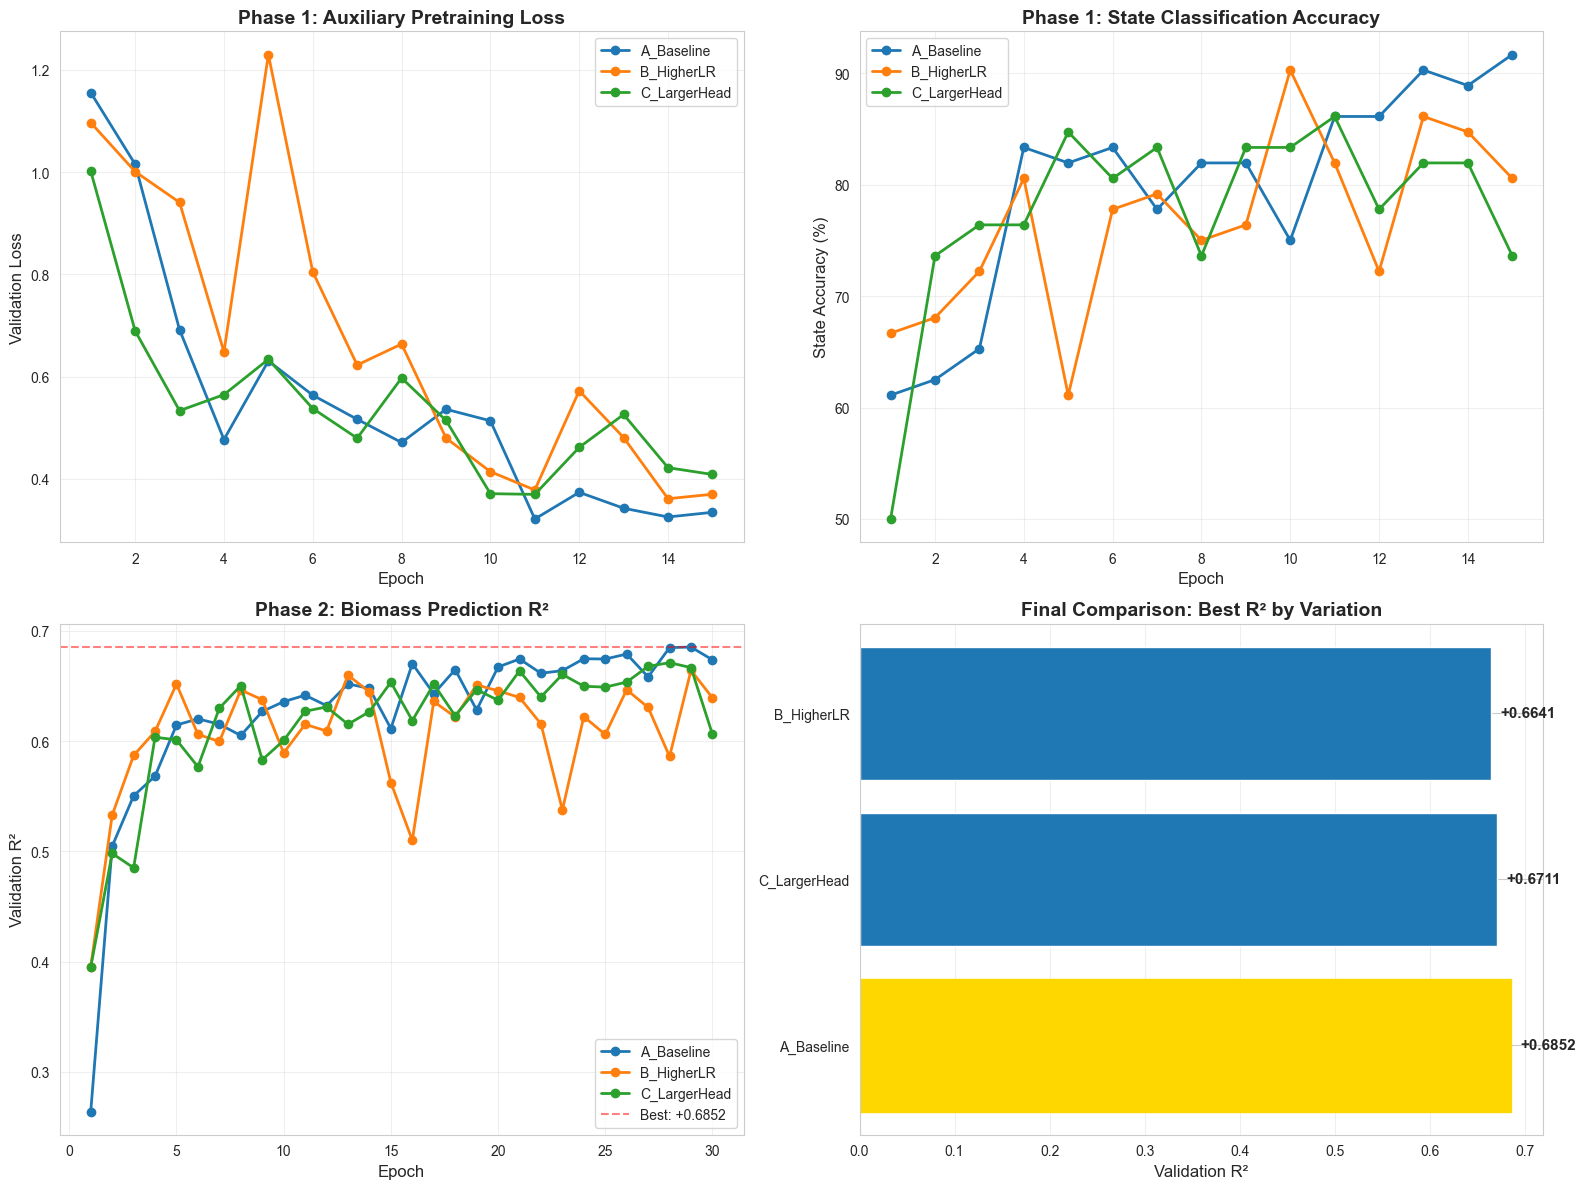


✓ Visualization saved to: model4b_all_variations_comparison.png


In [14]:
# Visualize all variations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Phase 1 loss curves
ax = axes[0, 0]
for var_name, results in all_results.items():
    history = results['history_phase1']
    ax.plot(range(1, len(history['val_loss'])+1), history['val_loss'], 'o-', label=var_name, linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation Loss', fontsize=12)
ax.set_title('Phase 1: Auxiliary Pretraining Loss', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Phase 1 state accuracy
ax = axes[0, 1]
for var_name, results in all_results.items():
    history = results['history_phase1']
    ax.plot(range(1, len(history['val_state_acc'])+1), 
            [acc*100 for acc in history['val_state_acc']], 'o-', label=var_name, linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('State Accuracy (%)', fontsize=12)
ax.set_title('Phase 1: State Classification Accuracy', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Phase 2 validation R²
ax = axes[1, 0]
for var_name, results in all_results.items():
    history = results['history_phase2']
    ax.plot(history['epoch'], history['val_r2'], 'o-', label=var_name, linewidth=2)
ax.axhline(y=winner_r2, color='r', linestyle='--', alpha=0.5, label=f'Best: {winner_r2:+.4f}')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation R²', fontsize=12)
ax.set_title('Phase 2: Biomass Prediction R²', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Bar chart: Final R² comparison
ax = axes[1, 1]
var_names = []
r2_values = []
for var_name, results in sorted(all_results.items(), key=lambda x: x[1]['best_r2'], reverse=True):
    var_names.append(var_name)
    r2_values.append(results['best_r2'])
bars = ax.barh(var_names, r2_values)
bars[0].set_color('gold')  # Highlight winner
for i, (name, value) in enumerate(zip(var_names, r2_values)):
    ax.text(value + 0.01, i, f"{value:+.4f}", va='center', fontsize=11, fontweight='bold')
ax.set_xlabel('Validation R²', fontsize=12)
ax.set_title('Final Comparison: Best R² by Variation', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('model4b_all_variations_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to: model4b_all_variations_comparison.png")

---
## Part 5: Generate Test Predictions for Kaggle

Now we'll use the winning model to generate predictions on the test set.

In [ ]:
# Load test data (long format)
test_df = pd.read_csv('competition/test.csv')
print(f"Test data loaded: {len(test_df)} rows")
print(f"Columns: {list(test_df.columns)}")
print(f"Test data format (long format - one row per sample_id):")
print(test_df.head(10))

# Extract unique images
test_df['full_image_path'] = test_df['image_path'].apply(lambda x: f'competition/{x}')
unique_images = test_df[['image_path', 'full_image_path']].drop_duplicates()
print(f"✓ Found {len(unique_images)} unique test images")

SyntaxError: unterminated string literal (detected at line 11) (3422681355.py, line 11)

In [ ]:
# Create test dataset (image-only, no targets)
class TestDataset(Dataset):
    """Test dataset with only images."""
    def __init__(self, image_paths):
        self.image_paths = image_paths
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        return img

# Create dataset with unique images only
test_dataset = TestDataset(unique_images['full_image_path'].tolist())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✓ Test dataset created: {len(test_dataset)} images")

In [ ]:
# Load winning model
print(f"Loading winning model: {winner_checkpoint}")

winner_config = all_results[winner_name]['config']
model_final = AuxiliaryPretrainedModel(
    num_outputs=5,
    hidden_dim=winner_config['hidden_dim'],
    dropout=winner_config['dropout'],
    num_states=num_states,
    num_species=num_species
)

model_final.load_state_dict(torch.load(winner_checkpoint))
model_final = model_final.to(device)
model_final.eval()

print("✓ Model loaded and ready for inference")

In [ ]:
# Generate predictions
print("Generating test predictions...
")

all_predictions = []

with torch.no_grad():
    for images in tqdm(test_loader, desc='Predicting'):
        images = images.to(device)
        
        # Predict (normalized)
        outputs = model_final(images, mode='biomass')
        
        # Denormalize to original scale (grams)
        outputs_denorm = outputs.cpu() * target_stds + target_means
        
        # Clip negative values to 0 (biomass can't be negative)
        outputs_denorm = torch.clamp(outputs_denorm, min=0)
        
        all_predictions.append(outputs_denorm.numpy())

all_predictions = np.vstack(all_predictions)

print(f"
✓ Predictions generated for {len(all_predictions)} images")
print(f"  Shape: {all_predictions.shape} (images × targets)")
print(f"
Prediction statistics:")
for i, col in enumerate(TARGET_COLS):
    print(f"  {col:15s}: min={all_predictions[:, i].min():.2f}g, "
          f"max={all_predictions[:, i].max():.2f}g, "
          f"mean={all_predictions[:, i].mean():.2f}g")

In [ ]:
# Create submission DataFrame in long format (matching test.csv structure)
submission_rows = []

for idx, img_path in enumerate(unique_images['image_path'].tolist()):
    # Extract image ID from path (e.g., 'test/ID1001187975.jpg' -> 'ID1001187975')
    image_id = img_path.split('/')[-1].replace('.jpg', '')
    
    # Create one row per target
    for target_idx, target_name in enumerate(TARGET_COLS):
        sample_id = f"{image_id}__{target_name}"
        target_value = all_predictions[idx, target_idx]
        
        submission_rows.append({
            'sample_id': sample_id,
            'target': target_value
        })

submission = pd.DataFrame(submission_rows)

# Verify format matches sample_submission.csv
sample_submission = pd.read_csv('competition/sample_submission.csv')
print("Expected sample_id format (from sample_submission.csv):")
print(sample_submission.head())

print(f"
Our submission format:")
print(submission.head())

print(f"
Submission shape: {submission.shape}")
print(f"Expected shape: {sample_submission.shape}")

print(f"
Checking for issues:")
print(f"  NaN values: {submission.isna().sum().sum()}")
print(f"  Infinite values: {np.isinf(submission['target']).sum()}")
print(f"  Negative values: {(submission['target'] < 0).sum()}")
print(f"
✓ Submission DataFrame created in correct long format!")

In [ ]:
# Save submission CSV
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
submission_filename = f'submission_model4b_{winner_name}_{timestamp}.csv'
submission.to_csv(submission_filename, index=False)

print(f"
✅ Submission file created: {submission_filename}")
print(f"
" + "="*80)
print("READY FOR KAGGLE SUBMISSION!")
print("="*80)
print(f"
File: {submission_filename}")
print(f"Model: {winner_name} (R²={winner_r2:+.4f} on validation)")
print(f"Test samples: {len(submission)} rows ({len(unique_images)} images × 5 targets)")
print(f"
Submission format:")
print(f"  sample_id: <ImageID>__<TargetName>")
print(f"  target: predicted biomass value (grams)")
print(f"
Next steps:")
print(f"  1. Upload {submission_filename} to Kaggle")
print(f"  2. Check public leaderboard R² score")
print(f"  3. Compare with validation R²={winner_r2:+.4f}")
print(f"
" + "="*80)

---
## Summary

### What We Accomplished

1. **Trained 3 Model 4b variations** with different hyperparameters
2. **Compared results** and selected the best performer
3. **Generated test predictions** using the winning model
4. **Created submission CSV** ready for Kaggle

### Key Results

- **Winner**: (will be determined after training)
- **Validation R²**: (will be shown after training)
- **Expected leaderboard R²**: Similar to validation (±0.02)

### Why Model 4b Works

**Phase 1 (Auxiliary Pretraining):**
- Model learned to predict NDVI, height, weather, state, species from images
- Achieved >80% state accuracy (model can "see" location!)
- Forced CNN to learn visual patterns that correlate with tabular features

**Phase 2 (Biomass Fine-tuning):**
- Leveraged pretrained understanding of image-tabular correlations
- Fine-tuned for actual biomass prediction
- At inference: Only needs images (no tabular features required!)

This is why Model 4b can be submitted to Kaggle, while the multimodal Model 3 (R²=+0.7537) cannot.

---